# ЗАДАНИЕ

Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.

В результате работы должен получиться:

- Jupyter-ноутбук с моделью 

- Признаки, влияющие больше всего на уровень продаж

- Датасет, если после ваших манипуляций он отличается от исходного;

- Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)



Баллы      Что надо сделать

10          Провести EDA

10          Обработать категориальные признаки 

10          Устранить пропущенные значения

10          Изучить корреляцию признаков с данными о продажах

10          Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели

20          Построить и подобрать оптимальные параметры для любой линейной модели

20          Построить и подобрать оптимальные параметры для любой нелинейной модели

20          Провести стекинг нескольких моделей

10          Оценить качество модели на отложенной выборке

10          Выбрать топ 3 признака больше всего влияющие на объемы продаж



In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedShuffleSplit, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.feature_selection import SelectFromModel
from math import sqrt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# 1. EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Исходные данные состоят из 12 признаков и содержат 8523 строчек; 7 признаков являются категориальными, а признаки Item_Weight, Outlet_Size имеют пропущенные значения.

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


Наблюдаются отсутствующие значения, нулевые значения Item visibility и также разброс в диапазонах значений признаков, которые надо нормализовать.

In [5]:
feat_ignore = ['Item_Identifier','Outlet_Identifier']
feat_y = ['Item_Outlet_Sales']
feat_num = [c for c,t in zip(data.columns, data.dtypes) if t != "object" and c not in (feat_ignore + feat_y)]
feat_cat = [c for c,t in zip(data.columns, data.dtypes) if t == "object" and c not in (feat_ignore + feat_y)]
print(feat_num, feat_cat)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'] ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


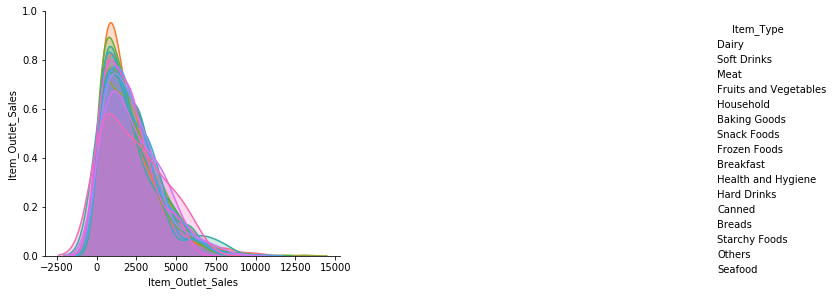

In [8]:
g=sns.pairplot(data=data[['Item_Outlet_Sales','Item_Type']], hue='Item_Type',plot_kws={'alpha':0.2});
g.fig.set_size_inches(15,5)

Продажи в магазине имеют экспоненциальное распределение

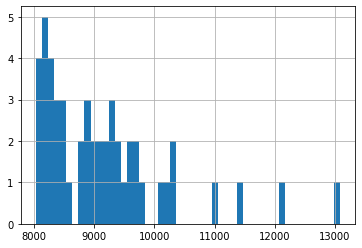

In [9]:
data[data['Item_Outlet_Sales']>8000]['Item_Outlet_Sales'].hist(bins=50);

Есть выбивающиеся значения в признаке Item_Outlet_Sales

In [10]:
data[data['Item_Outlet_Sales']>10000]['Item_Outlet_Sales'].value_counts()

13086.9648    1
11445.1020    1
10236.6750    1
10306.5840    1
10993.6896    1
10256.6490    1
12117.5600    1
10072.8882    1
Name: Item_Outlet_Sales, dtype: int64

In [13]:
data.profile_report()

# 2. Обработаем категориальные признаки

In [36]:
_ = [print(c, len(data[c].unique())) for c in feat_cat]

Item_Fat_Content 2
Item_Type 16
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4


Обработаем категориальные признаки с помощью LabelEncoder:

In [39]:
categ_features = [i for i in data.columns if data[i].dtype.name == 'object']
for i in categ_features:
    try:
        le = LabelEncoder()
        data[i] = le.fit_transform(data[i])
    except:
        continue

In [40]:
df = pd.concat([data[feat_num + feat_y],pd.get_dummies(data[feat_cat])],axis=1)
print(df.shape)

(8519, 34)


# 3. Устраним пропущенные значения

Заполним отсутствующие значения в категорийных признаках 

Для данных трёх магазинов нельзя восстановить информацию о размере. Для них будет введена новая категория N/A

In [14]:
data['Outlet_Size'] = data['Outlet_Size'].fillna('N/A')

In [15]:
data[data['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,N/A,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
33,FDO23,17.850,Low Fat,0.0,Breads,93.1436,OUT045,2002,N/A,Tier 2,Supermarket Type1,2174.5028
46,NCP05,19.600,Low Fat,0.0,Health and Hygiene,153.3024,OUT045,2002,N/A,Tier 2,Supermarket Type1,2428.8384
60,FDM20,10.000,Low Fat,0.0,Fruits and Vegetables,246.9144,OUT018,2009,Medium,Tier 3,Supermarket Type2,3185.1872
72,FDH35,18.250,Low Fat,0.0,Starchy Foods,164.7526,OUT045,2002,N/A,Tier 2,Supermarket Type1,4604.6728
79,FDV25,5.905,Low Fat,0.0,Canned,222.5456,OUT045,2002,N/A,Tier 2,Supermarket Type1,5305.0944


Есть 526 рядов с продажами без видимости. Отфильтруем их, чтобы очистить данные.

In [18]:
print(len(data[np.isnan(data['Item_Weight'])]['Item_Identifier'].unique()))
data[np.isnan(data['Item_Weight'])].head()

1142


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


Отсутствуют значения в Item_Weight у 1142 уникальных значений Item_Identifier. 
Заполних их данными из других рядов для каждого Item_Identifier

In [19]:
data[data['Item_Identifier']=='DRI11']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,N/A,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,N/A,Tier 2,Supermarket Type1,1612.5676


In [21]:
max(data[(data['Item_Identifier']=='DRI11') & (~np.isnan(data['Item_Weight']))]['Item_Weight'].values)

8.26

In [22]:
data_weights = pd.DataFrame(data[np.isnan(data['Item_Weight'])]['Item_Identifier'].unique(),columns=['Item_Identifier'])

In [23]:
data_weights.head()

,Item_Identifier
0,FDP10
1,DRI11
2,FDW12
3,FDC37
4,FDC14


In [25]:
data_weights['weight'] = data_weights.apply(lambda x: max(data[(data['Item_Identifier']==x['Item_Identifier']) & (~np.isnan(data['Item_Weight']))]['Item_Weight'].values) if len(data[(data['Item_Identifier']==x['Item_Identifier']) & (~np.isnan(data['Item_Weight']))]['Item_Weight']) > 0 else np.nan, axis=1)

In [26]:
data_weights.head()

,Item_Identifier,weight
0,FDP10,19.000
1,DRI11,8.260
2,FDW12,8.315
3,FDC37,15.500
4,FDC14,14.500


Новый датасет с присвоенными значениями веса

In [27]:
print(len(data_weights[data_weights['Item_Identifier']=='FDP10']))
data_weights[data_weights['Item_Identifier']=='FDP10']['weight'].values[0]

1


19.0

Заполним значениями оригинальный датасет

In [28]:
data['Item_Weight'] = data.apply(lambda x: (data_weights[data_weights['Item_Identifier']==x['Item_Identifier']]['weight'].values[0]) if np.isnan(x['Item_Weight']) else x['Item_Weight'], axis=1)

In [29]:
print(len(data[np.isnan(data['Item_Weight'])]['Item_Identifier'].unique()))
data[np.isnan(data['Item_Weight'])]

4


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


Есть 4 отличных Item_Identifier с NaN-значениями в Item_Weight. Удалим их.

In [31]:
data.dropna(inplace=True)

В признаке Item_Fat_Content встречаются 5 категорий жирности, но по существу это только два признака: Low Fat и Regular, исправим:

In [32]:
data.loc[data['Item_Fat_Content'].isin(['Low Fat', 'LF', 'low fat']), 'Item_Fat_Content'] = 'Low Fat'
data.loc[data['Item_Fat_Content'].isin(['Regular', 'reg']), 'Item_Fat_Content'] = 'Regular'

In [34]:
data.shape

(8519, 12)

В датасете нет дубликатов

In [35]:
data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

# 4. Изучим корреляцию признаков с данными о продажах

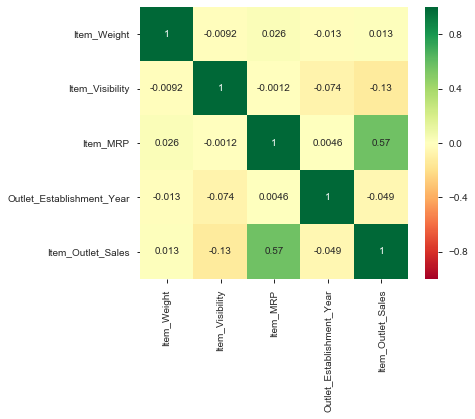

In [42]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(data.corr(),annot=True,cmap="RdYlGn",vmin=-1,vmax=1)
plt.show()

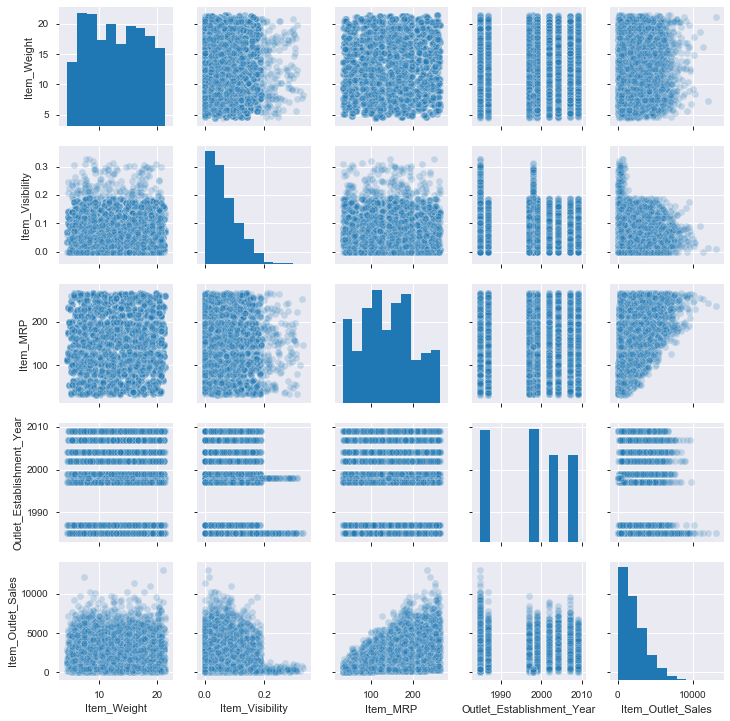

In [43]:
g=sns.pairplot(data,plot_kws={'alpha':0.2});
g.fig.set_size_inches(10,10)

Есть одна сильная зависимость между Item_Outlet_Sales и Item_MRP.

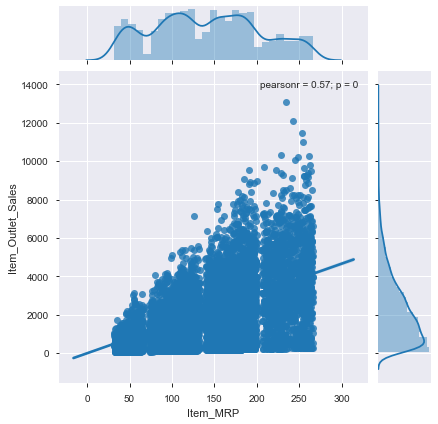

In [48]:
sns.jointplot(data=data,y='Item_Outlet_Sales',x='Item_MRP',kind='reg',stat_func=pearsonr)

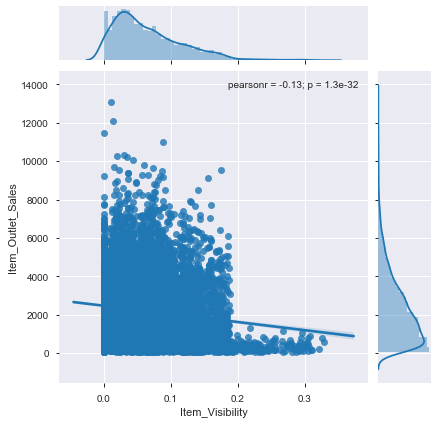

In [49]:
sns.jointplot(data=data,y='Item_Outlet_Sales',x='Item_Visibility',kind='reg',stat_func=pearsonr)

А между Item_Visibility и Item_Outlet_Sales, к примеру, нет сильной корреляции.

# 5. Выберем метрики, на основе которых будем измерять качество полученной модели

В нашем случае будет решаться задача регрессии, поэтому выбираем для оценки моделей основные метрики регрессии MAE и RMSE. 

MAE - средняя абсолютная ошибка - представляет собой сумму абсолютных различий между прогнозами и фактическими значениями. Это дает представление о том, насколько неправильными были прогнозы.
Root-mean-square error (RMSE) - cреднеквадратичное отклонение или среднеквадратичная ошибка - мера различий между значениями, предсказанными моделью или оценщиком, и наблюдаемыми значениями.

In [50]:
def get_mae_percent(y_actual, y_predicted):
    assert y_actual.values.mean()!=0
    return mean_absolute_error(y_true=y_actual.values, y_pred=y_predicted)/y_actual.values.mean()

def get_rmse(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual.values, y_predicted))

def get_metrics(y_actual, y_predicted):
    return get_mae_percent(y_actual, y_predicted), get_rmse(y_actual, y_predicted)

In [51]:
def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def predict_and_test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mtrx = get_metrics(y_test, y_pred)
    print(f'MAE% = {mtrx[0]}, RMSE = {mtrx[1]}')
    return model, mtrx[0], mtrx[1]

def fit_and_test(model, X_train, y_train, X_test, y_test):
    model = fit_model(model, X_train, y_train)
    return predict_and_test(model, X_test, y_test)

# 6. Построим и подберем оптимальные параметры для линейной модели

In [60]:
models = []
RANDOM_STATE = 7
N_FOLDS = 3

Разделим данные на обучающие и проверочные:

In [61]:
df_train_and_valid, df_test = train_test_split(df, random_state=RANDOM_STATE, test_size=0.3)
df_train, df_valid = train_test_split(df_train_and_valid, random_state=RANDOM_STATE, test_size=0.15)

Для нормализации функции применим StandardScaler:

In [62]:
sc = preprocessing.StandardScaler()
df_train[feat_num] = sc.fit_transform(df_train[feat_num])
df_valid[feat_num], df_test[feat_num] = sc.transform(df_valid[feat_num]), sc.transform(df_test[feat_num])

Разделим данные на х и у:

In [63]:
X_train, X_valid, X_test, y_train, y_valid, y_test = df_train.drop(feat_y, axis=1), df_valid.drop(feat_y, axis=1), df_test.drop(feat_y, axis=1), df_train[feat_y].squeeze(), df_valid[feat_y].squeeze(), df_test[feat_y].squeeze()
assert df.shape[0] == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]
assert df.shape[0] == len(y_train) + len(y_valid) + len(y_test)
print(X_train.shape, X_valid.shape, X_test.shape, len(y_train), len(y_valid), len(y_test))

(5068, 33) (895, 33) (2556, 33) 5068 895 2556


Проверим, что после работы StandardScaler mean = 0 и standard deviation = 1

In [64]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,5068.0,2.505669e-16,1.000099,-1.793197,-0.866735,-0.063369,0.854454,1.826268
Item_Visibility,5068.0,1.566536e-16,1.000099,-1.289703,-0.765809,-0.235403,0.573502,4.928020
Item_MRP,5068.0,-1.049542e-16,1.000099,-1.778660,-0.760639,0.027024,0.728097,2.025632
Outlet_Establishment_Year,5068.0,-1.135282e-14,1.000099,-1.517691,-1.280151,0.145088,0.738937,1.332787
Item_Fat_Content_Low Fat,5068.0,6.499605e-01,0.477029,0.000000,0.000000,1.000000,1.000000,1.000000
Item_Fat_Content_Regular,5068.0,3.500395e-01,0.477029,0.000000,0.000000,0.000000,1.000000,1.000000
Item_Type_Baking Goods,5068.0,7.280979e-02,0.259850,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Type_Breads,5068.0,2.959747e-02,0.169491,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Type_Breakfast,5068.0,1.479874e-02,0.120758,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Type_Canned,5068.0,7.261247e-02,0.259525,0.000000,0.000000,0.000000,0.000000,1.000000


Потренируем модель:

In [65]:
model_linear = LinearRegression(n_jobs=-1)
models.append(fit_and_test(model_linear, X_train, y_train, X_valid, y_valid))

MAE% = 0.36987085203602343, RMSE = 1053.3884605494968


In [66]:
print('Coefficients: \n', model_linear.coef_, "\n")
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_linear.coef_.T):
    print(feature, coeff)

Coefficients: 
 [-4.80444755e+00 -7.32003446e+00  9.58500691e+02  3.17899385e+02
 -2.51440371e+01  2.51440371e+01 -2.16540198e+01  2.25055492e+01
  6.39852539e+00  4.38680618e+01 -9.01992633e+01 -5.68284504e+01
  2.25996587e+01 -1.59748656e+01  3.57981691e+01  2.39302861e+01
  5.20081140e+00 -4.57089850e+00  1.09620637e+02 -9.10612151e+00
 -7.21353483e+01  5.47268448e-01  6.23712193e+02 -1.64754485e+02
 -2.92167305e+02 -1.66790403e+02  1.96617201e+02  2.25342464e+01
 -2.19151448e+02 -1.59880446e+03 -1.07887139e+02 -4.98685768e+02
  2.20537737e+03] 

Feature:  Weight:
Item_Weight -4.804447551062629
Item_Visibility -7.32003445848176
Item_MRP 958.5006910096828
Outlet_Establishment_Year 317.89938454744583
Item_Fat_Content_Low Fat -25.144037080831193
Item_Fat_Content_Regular 25.144037080819455
Item_Type_Baking Goods -21.654019815794214
Item_Type_Breads 22.505549174904342
Item_Type_Breakfast 6.3985253924854995
Item_Type_Canned 43.86806176292008
Item_Type_Dairy -90.1992633140195
Item_Type_Fro

Применим регуляризацию:

In [67]:
model_L1 = Lasso(random_state=RANDOM_STATE)
models.append(fit_and_test(model_L1, X_train, y_train, X_valid, y_valid))

MAE% = 0.3705594574043312, RMSE = 1055.25141807751


In [68]:
print('Coefficients: \n', model_L1.coef_)
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_L1.coef_.T):
    print(feature, coeff)

Coefficients: 
 [-2.74802679e+00 -7.23430576e+00  9.57578667e+02  5.58582482e+01
 -4.39952070e+01  3.15514673e-15 -8.68115671e+00  0.00000000e+00
  0.00000000e+00  2.88251683e+01 -8.23711734e+01 -4.54603967e+01
  1.44420323e+01 -0.00000000e+00  1.36080098e+01  8.98765749e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.38022310e+00
 -5.63940403e+01 -0.00000000e+00  3.56333409e+01  3.76604633e+01
 -1.04789234e+02 -0.00000000e+00 -0.00000000e+00  2.16218382e+01
 -0.00000000e+00 -1.88966429e+03  0.00000000e+00 -4.77024150e+02
  1.46300789e+03]
Feature:  Weight:
Item_Weight -2.748026793712428
Item_Visibility -7.23430576087023
Item_MRP 957.5786671359209
Outlet_Establishment_Year 55.858248217494186
Item_Fat_Content_Low Fat -43.995207035982496
Item_Fat_Content_Regular 3.1551467281807177e-15
Item_Type_Baking Goods -8.681156705493038
Item_Type_Breads 0.0
Item_Type_Breakfast 0.0
Item_Type_Canned 28.82516830836798
Item_Type_Dairy -82.37117340212981
Item_Type_Frozen Foods -45.46039673276088

In [69]:
model_L2 = Ridge()
models.append(fit_and_test(model_L2, X_train, y_train, X_valid, y_valid))

print('Coefficients: \n', model_L2.coef_)
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_L2.coef_.T):
    print(feature, coeff)

MAE% = 0.3699008556438967, RMSE = 1053.5556095775853
Coefficients: 
 [-4.60620474e+00 -7.64193184e+00  9.58346596e+02  2.55388596e+02
 -2.51883030e+01  2.51883030e+01 -2.11257275e+01  2.13523898e+01
  8.05520311e+00  4.38836703e+01 -9.00862938e+01 -5.59579561e+01
  2.29083856e+01 -1.57414610e+01  3.55732791e+01  2.38098752e+01
  5.07661168e+00 -3.69867657e+00  1.06012292e+02 -9.24077628e+00
 -7.15070089e+01  6.86193433e-01  4.84261045e+02 -1.04463205e+02
 -2.53157321e+02 -1.26640519e+02  1.41811010e+02  2.55519537e+01
 -1.67362964e+02 -1.60240169e+03 -2.27560469e+01 -4.48183866e+02
  2.07334160e+03]
Feature:  Weight:
Item_Weight -4.60620473544342
Item_Visibility -7.64193184285911
Item_MRP 958.3465964936036
Outlet_Establishment_Year 255.3885963060192
Item_Fat_Content_Low Fat -25.188302968386264
Item_Fat_Content_Regular 25.18830296838837
Item_Type_Baking Goods -21.125727526429518
Item_Type_Breads 21.35238979934739
Item_Type_Breakfast 8.055203105367188
Item_Type_Canned 43.88367032151947
I

In [70]:
models

[(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
  0.36987085203602343,
  1053.3884605494968),
 (Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=7,
        selection='cyclic', tol=0.0001, warm_start=False),
  0.3705594574043312,
  1055.25141807751),
 (Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
        normalize=False, random_state=None, solver='auto', tol=0.001),
  0.3699008556438967,
  1053.5556095775853)]

In [71]:
print(f'Лучший вариант для линейной модели: \
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0]}\n MAE%=\
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][1]}\n RMSE=\
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][2]}')

Лучший вариант для линейной модели:       LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
 MAE%=      0.36987085203602343
 RMSE=      1053.3884605494968


Сохраним лучший вариант модели для стекинга:

In [72]:
model_lr = sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0]

# 7. Построим и подберем оптимальные параметры для любой нелинейной модели

Потренируем RandomForest, который часто используется для моделирования в ритейле:

In [73]:
model_rf_def = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, random_state=RANDOM_STATE)
models.append(fit_and_test(model_rf_def, X_train, y_train, X_valid, y_valid))

MAE% = 0.34245219668491395, RMSE = 1032.5223705244


Результат уже лучше, чем у линейных моделей, но можно еще поработать над параметрами:

In [74]:
param_grid = {'n_estimators': list(range(50,250,50)),
              'max_depth': list(range(5,25,5)),
              'min_samples_leaf': list(range(1,31,10)),
              'max_features': list(np.linspace(0.6,1,5)),
             }
print(param_grid)

{'n_estimators': [50, 100, 150, 200], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 11, 21], 'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]}


In [75]:
model_rf_grd = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
grid = GridSearchCV(model_rf_grd, param_grid, cv=N_FOLDS, n_jobs=-1)

In [76]:
grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 11, 'n_estimators': 100}


In [77]:
model_rf = grid.best_estimator_
models.append(fit_and_test(model_rf, X_train, y_train, X_valid, y_valid))

MAE% = 0.3396784044140403, RMSE = 1022.706575210635


Использование Grid показало лучшие результаты модели

# 8. Проведем стекинг нескольких моделей

Задействуем в стекинге линейную и нелинейную модели

Функция для подготовки мета-фич для тренировки новой модели на основе предсказаний стекинга и y_actual. На выходе получим X предсказаний
под-моделей на данных TRAIN и X редсказаний под-моделей на данных VALID/TEST

In [78]:
def get_meta_features(clf, X_train, y_train, X_valid, y_valid, stack_cv):
    
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_valid = np.zeros_like(y_valid, dtype=float)
    
    for i, (train_ind, valid_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[valid_ind] = clf.predict(X_train.iloc[valid_ind])
        meta_valid += clf.predict(X_valid)
    
    return meta_train, meta_valid / stack_cv.n_splits

In [79]:
stack_cv = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(model_lr, X_train, y_train, X_valid, y_valid, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(model_rf, X_train, y_train, X_valid, y_valid, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

LR features...
RF features...


In [80]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [ ]:
Потренируем новую модель LinearRegression на предсказаниях лучшей линейной модели и модели randomforest

In [81]:
model_lr_meta = LinearRegression(n_jobs=-1)
_ = fit_and_test(model_lr_meta, X_meta_train, y_train, X_meta_test, y_valid)

MAE% = 0.34021679830264623, RMSE = 1020.7434785770369


Результат отчасти стал лучше по показателю RMSE

Посмотрим на вклад каждой под-модели в стекинге. Самый большой вклад в ансамбль показал RandomForest

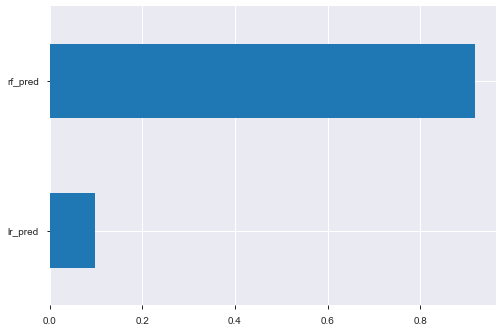

In [82]:
pd.Series(model_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh');

# 9. Оценим качество модели на отложенной выборке

Оценим точность ансамбля на датасете TEST

In [83]:
meta_test = []

_, meta_te = get_meta_features(model_lr, X_train, y_train, X_test, y_test, stack_cv)
meta_test.append(meta_te)

_, meta_te = get_meta_features(model_rf, X_train, y_train, X_test, y_test, stack_cv)
meta_test.append(meta_te)

X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

_ = predict_and_test(model_lr_meta, X_meta_test, y_test)

MAE% = 0.352986117335508, RMSE = 1107.0832585762682


Проверим точность на всех неансамблевых моделях и сравним с ансамблем: 

In [84]:
for m in models:
    print(m[0], predict_and_test(m[0], X_test, y_test))

MAE% = 0.3906515337805069, RMSE = 1159.0394581283917
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False) (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), 0.3906515337805069, 1159.0394581283917)
MAE% = 0.38986189073391814, RMSE = 1157.514954763232
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=7,
      selection='cyclic', tol=0.0001, warm_start=False) (Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=7,
      selection='cyclic', tol=0.0001, warm_start=False), 0.38986189073391814, 1157.514954763232)
MAE% = 0.38999460388958734, RMSE = 1158.1516088506933
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) (Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normali

На отложенной выборке лучший результат все равно показывает модель RandomForestRegressor. У ансамбля результаты хуже чем у леса, но лучше, чем у простых линейных моделей. 

# 10. Выберем топ 3 признака, больше всего влияющие на объемы продаж

Будем использовать лучшую модель для вычислений:

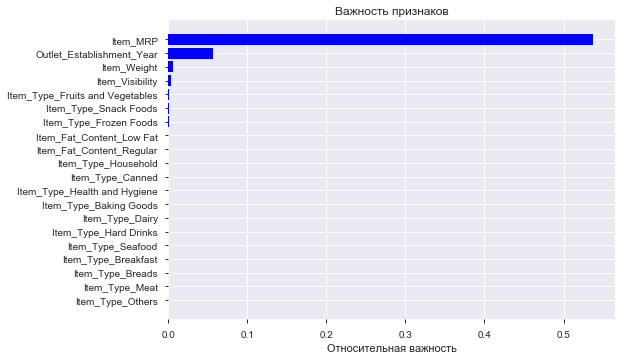

In [85]:
features = X_train.columns
importances = sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0].feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность')
plt.show()

Самый важный признак, влияющий на продажи - Максимальная цена продажи продукта, что логично. На втором месте, но с отставанием по значимости во много раз - Год открытия магазина. Возможно это объясняется тем, что чем дольше магазин работает тем больше у него база покупателей. На третьем месте - вес товара, но тк работать над этим признаком магазину сложно, чаще всего - вес принимается, как данность, то хочется на третье место поставить параметр - % полок, отведенный под наш продукт в конкретном магазине